In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

load_folder = base_location / Path(r'Figure_1_2')
# load_folder = base_location / Path(r'tmp')
h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
# h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
# load_folder = base_location / Path(r'Figure_3')
# h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

out_folder = base_location / Path(r'final_outputs')

out_loc = str((out_folder).resolve())
h5_recons_locations = glob.glob(h5_recons_locations)

In [5]:
base_keys = list({
                'gACH':(0,0),
                'rDA':(0,0),
                'gDA':(0,0),
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideInIndexnr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
                }.keys())
shortened_keys = [dfh.shorten_col_name(_) for _ in base_keys]
# base_keys

In [6]:
def get_delta_list(event_srs, event_col, keep_srs):
    
    keep_eg_lst = []
    delta_keep_eg_lst = []

    rdc = []
    entry_num = np.arange(len(event_srs))
    event = np.where(event_srs.values == 1)
    assert len(event) == 1
    event = event[0]
    
    for iev, ev in enumerate(event):
        delta = entry_num - ev
        keep_eg = (delta >= -40)&(delta <= 100)&keep_srs
        delta_keep_eg = delta[keep_eg]
        keep_eg_lst.append(keep_eg)
        delta_keep_eg_lst.append(delta_keep_eg)

    return keep_eg_lst, delta_keep_eg_lst

# full_df = h5_lst[0]


In [7]:


# resid_df = resid_df[~resid_df['dupe']]

# # display(resid_df)
# # break

# b0 = np.arange(len(resid_df))
# # display(b0)

# rdc = []

# lb = -40
# ub = 100

# pred_params_cols = [_ for _ in resid_df.columns if 'pred_paramsNum=' in _]


# true_col = pred_params_cols[0].replace('pred_paramsNum=0_', '').split('_')[0]
# print('true_col', true_col)

# for event_col in ['photometrySideInIndexr']:
#     resid_df_cutdown = resid_df[['Unnamed: 0', 'file_num', 'dupe', 'nTrial', 'nEndTrial', 'wi_trial_keep',
#                                 'gDA', 'gACH', 'rDA', event_col] + pred_params_cols].copy()

#     event = np.where(resid_df_cutdown[event_col].values == 1)[0]
#     print(b0.shape, event.shape)
#     for iev, ev in enumerate(event):
#         delta = b0 - ev
#         # print(delta)
#         keep_eg = (delta >= -40)&(delta <= 100)&(resid_df['is_holdout'])
#         delta_keep_eg = delta[keep_eg]
#         rdf_tmp = resid_df_cutdown.loc[keep_eg].copy()
#         rdf_tmp['delta'] = delta_keep_eg
#         # rdf_tmp = rdf_tmp[~rdf_tmp['dupe']]
#         # display(rdf_tmp)
#         # display(list(rdf_tmp.columns))
#         rdc.append(rdf_tmp.set_index('delta'))

#     # rdc_df = pd.concat(rdc, axis=0)
#     # display(rdc_df)
#     # rdc_df = rdc_df[[true_col]]
#     # delta_index.append(delta)
#     # delta_val.append((bs.confidence_interval.low, mn_val, bs.confidence_interval.high))

#     reconstruction_data_list = []

#     seed = np.random.randint(1000000000)
#     for bootstrap_col in [true_col] + pred_params_cols:
#         rdc_lst = []
#         for rdc_df in rdc:
#             rdc_lst.append(rdc_df[[bootstrap_col]])
#         rdc_df = pd.concat(rdc_lst, axis=1)

#         for delta in rdc_df.index:
#             row = rdc_df.loc[delta].dropna().values
#             mn_val = row.mean()
#             bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                                        batch=None, vectorized=True, paired=False,
#                                        axis=0, confidence_level=0.95, method='BCa',
#                                        random_state=seed)

#             rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)
#             reconstruction_data_list.append(rtup)
#             print(reconstruction_data_list[-1])

In [8]:
h5_lst = defaultdict(list)
run_id_dct = defaultdict(list)

for h5_coef_fn in h5_recons_locations:
    h5f = pd.HDFStore(h5_coef_fn)
    h5fk = h5f.keys()
    for key in h5fk:
        
        resp = key.split('_')[0].replace('/', '')
        model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
        
        if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
            continue
        if 'base_simple' not in key and 'base_words' not in key and 'basis' not in key:
            continue
        print(key, model_version)
        
        y_col = key.split('_')[0].replace(r'/', r'')
        h5_df = pd.read_hdf(h5f, key)
        
        h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]
        
        if 'dfrel_basis' != key.replace('/', ''):
            h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
            h5_df['true'] = h5_lst['dfrel'][0][y_col]
            h5_df['resid2'] = (h5_df['true'] - h5_df['pred'])**2

            h5_df['file_num'] = h5_lst['dfrel'][0]['file_num']
            
            h5_df['dupe'] = h5_lst['dfrel'][0]['dupe']
            h5_df['wi_trial_keep'] = h5_lst['dfrel'][0]['wi_trial_keep']
            
#             h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
            h5_lst[y_col].append(h5_df)
            run_id_dct[y_col].append(model_version)
        else:
            h5_lst[y_col].append(h5_df)
            run_id_dct[y_col].append('basis')
        
# concat = pd.concat(h5_lst, axis=0)

/dfrel_basis 
/gACH_0_0_base_simple_run_num__0 base_simple
/gACH_0_8_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_1_0_base_simple_run_num__0 base_simple
/rDA_1_8_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_2_0_base_simple_run_num__0 base_simple
/gDA_2_8_base_words_run_num__0 base_words


Pulling delta list


  0%|          | 0/555 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAA
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAA
Pulling delta list


  0%|          | 0/159 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAa
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAa
Pulling delta list


  0%|          | 0/99 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaA
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaA
Pulling delta list


  0%|          | 0/96 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaa
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaa
Pulling delta list


  0%|          | 0/14 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAB
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAB
Pulling delta list


  0%|          | 0/35 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAb
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIAb
Pulling delta list


  0%|          | 0/95 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaB
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIaB
Pulling delta list


  0%|          | 0/68 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIab
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIab
Pulling delta list


  0%|          | 0/763 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIr
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SIr
Pulling delta list


  0%|          | 0/358 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SInr
save_file -- Figure_1_2-reconstruct-gACH=base_simple-SInr


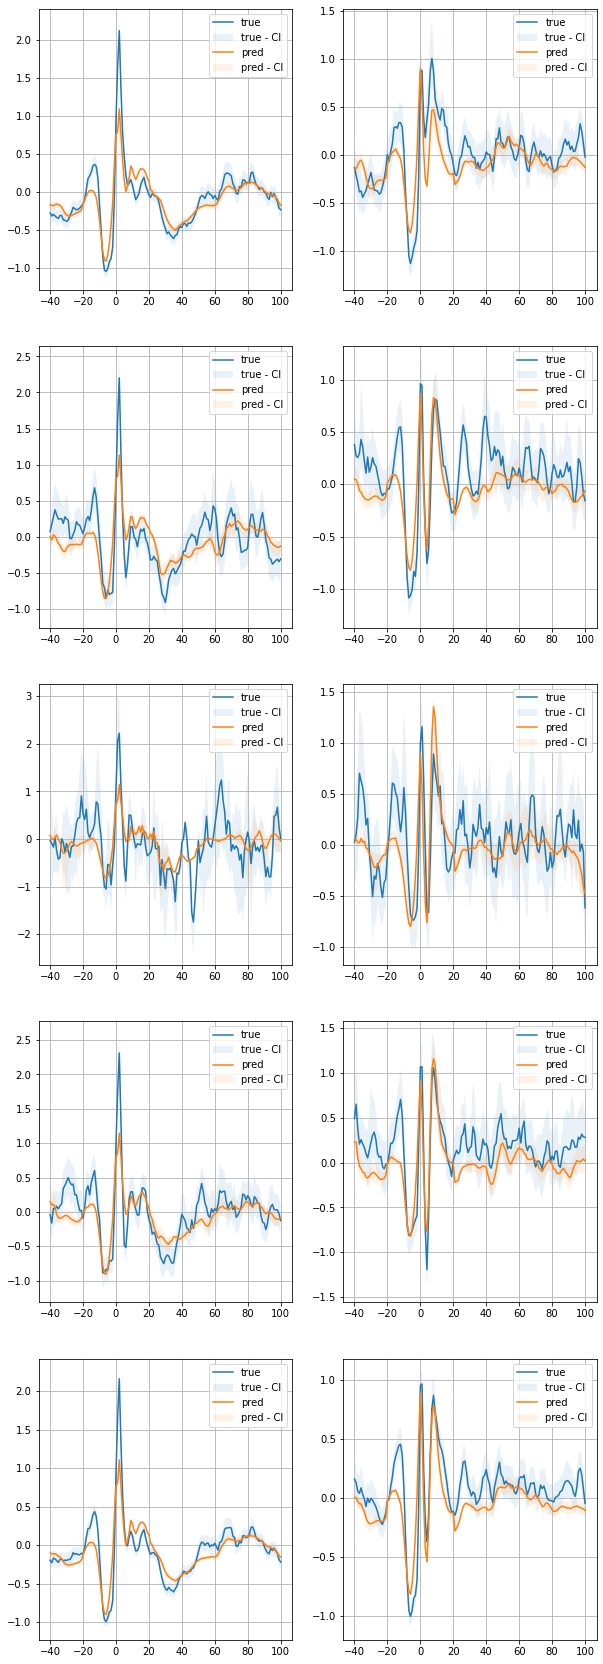

In [28]:
all_alignment_cols = [
                        'SIAA', 'SIAa', 'SIaA', 'SIaa',
                        'SIAB', 'SIAb', 'SIaB', 'SIab',
                        'SIr', 'SInr', 
                     ]
i = 2

for i in range(2):
    for y_col in ['gACH', 'rDA', 'gDA']:
        fig,axes = plt.subplots(5,2,figsize=(10,30))
        
        combo_rdc_by_ac = {}
        
        for iac, alignment_col in enumerate(all_alignment_cols):
            ic, ir = iac%2, iac//2
            ax = axes[ir, ic]
            # keep_rows, assoc_deltas = get_delta_list(h5_lst[0][alignment_col], alignment_col, ((h5_lst[i]['holdout']==0)*0+1).astype(bool))
#             keep_rows, assoc_deltas = get_delta_list(h5_lst['dfrel'][0][alignment_col], alignment_col, (h5_lst[y_col][i]['holdout']==1).astype(bool))
            
            dupe = h5_lst['dfrel'][0]['dupe']
            dfrel_basis = h5_lst['dfrel'][0].loc[~dupe].iloc[:100000]
            dfrel_basis_run = h5_lst[y_col][i].loc[~dupe].iloc[:100000]
            
            model_version = run_id_dct[y_col][i]
            
            print('Pulling delta list')
            keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
            rdc_lst = defaultdict(list)
            for entry_num in trange(len(keep_rows)):
                keep_row_single = keep_rows[entry_num]
                deltas = assoc_deltas[entry_num]
                rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)
                
#                 print('file_num', rdc_df['file_num'].nunique())
                if rdc_df['file_num'].nunique() > 1:
                    continue
                    
                reconstruction_data_list = []

                for bootstrap_col in ['true', 'pred']:
                    rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

            print('keys', rdc_lst.keys())

            combo_rdc = {}
            seed = np.random.randint(1000000000)
            for bootstrap_col in (rdc_lst):
                tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

                reconstruction_data_list = []
                for delta in (tmp_rdc.index):
                    row = tmp_rdc.loc[delta].dropna().values
                    bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
                                               batch=None, vectorized=True, paired=False,
                                               axis=0, confidence_level=0.95, method='BCa',
                                               random_state=seed)

                    mn_val = row.mean()
                    rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

                    reconstruction_data_list.append(rtup)

                tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'boot_lower_bound', 'mean', 'boot_upper_bound']).set_index('delta')
                combo_rdc[bootstrap_col] = tmp_combo_rdc.drop('basis_column',axis=1)

                # if bootstrap_col == 'true':
                ax.plot(tmp_combo_rdc.index, tmp_combo_rdc['mean'], label=f'{bootstrap_col}')#, color='b')
                ax.fill_between(tmp_combo_rdc.index, tmp_combo_rdc['boot_lower_bound'], tmp_combo_rdc['boot_upper_bound'], alpha=0.1, label=f'{bootstrap_col} - CI')#, color='b')
                ax.grid(True)
                ax.legend()
                
                print('save_file --', f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}-{alignment_col}')
                combo_rdc[bootstrap_col].to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}-{alignment_col}-{bootstrap_col}.csv').resolve()))
            
            combo_rdc_w_tp = pd.concat(combo_rdc, axis=1)
            combo_rdc_w_tp.columns = ['_'.join(_) for _ in combo_rdc_w_tp.columns]
            
            combo_rdc_by_ac[alignment_col] = combo_rdc_w_tp
        
        combo_rdc_w_tp_w_ac = pd.concat(combo_rdc_by_ac, axis=1)
        combo_rdc_w_tp_w_ac.columns = ['_'.join(_) for _ in combo_rdc_w_tp_w_ac.columns]
        break
    break
                
                
                
#             # plt.suptitle(alignment_col)
#             ax.set_title(alignment_col)
#         plt.suptitle(y_col)
#     plt.show()

In [29]:
combo_rdc_w_tp_w_ac

,SIAA_true_boot_lower_bound,SIAA_true_mean,SIAA_true_boot_upper_bound,SIAA_pred_boot_lower_bound,SIAA_pred_mean,SIAA_pred_boot_upper_bound,SIAa_true_boot_lower_bound,SIAa_true_mean,SIAa_true_boot_upper_bound,SIAa_pred_boot_lower_bound,...,SIr_true_boot_upper_bound,SIr_pred_boot_lower_bound,SIr_pred_mean,SIr_pred_boot_upper_bound,SInr_true_boot_lower_bound,SInr_true_mean,SInr_true_boot_upper_bound,SInr_pred_boot_lower_bound,SInr_pred_mean,SInr_pred_boot_upper_bound
delta,,,,,,,,,,,,,,,,,,,,,
-40,-0.359451,-0.272759,-0.183200,-0.208245,-0.166720,-0.129923,-0.350245,-0.129309,0.102033,-0.232084,...,-0.111383,-0.137141,-0.099351,-0.062592,0.013442,0.159745,0.328202,-0.051098,0.002910,0.061743
-39,-0.397817,-0.312571,-0.226027,-0.209948,-0.167126,-0.126911,-0.423957,-0.212391,0.010985,-0.234712,...,-0.147630,-0.150978,-0.113685,-0.074935,-0.023639,0.128299,0.284814,-0.056086,0.003083,0.060213
-38,-0.378265,-0.289726,-0.199858,-0.222943,-0.180517,-0.141456,-0.481031,-0.286148,-0.071782,-0.193020,...,-0.076502,-0.152184,-0.112984,-0.073340,-0.082302,0.054773,0.195486,-0.082330,-0.030310,0.023199
-37,-0.405062,-0.311704,-0.218138,-0.209885,-0.162984,-0.120966,-0.594227,-0.384058,-0.125793,-0.150886,...,-0.087061,-0.149962,-0.109716,-0.071646,-0.103218,0.038268,0.188164,-0.097330,-0.050435,-0.004049
-36,-0.423311,-0.331474,-0.234030,-0.199599,-0.153212,-0.111463,-0.568734,-0.373621,-0.161067,-0.137059,...,-0.107394,-0.160154,-0.123431,-0.086021,-0.063828,0.084794,0.268801,-0.100746,-0.050763,-0.001593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.129401,-0.017466,0.099659,-0.093526,-0.041756,0.004277,-0.010137,0.184120,0.402848,-0.120455,...,0.060872,-0.097529,-0.053524,-0.012426,0.080292,0.225537,0.375817,-0.133193,-0.076824,-0.020588
97,-0.180014,-0.069727,0.038298,-0.118959,-0.069898,-0.022062,0.144883,0.326906,0.502038,-0.127445,...,0.021169,-0.121840,-0.078365,-0.038336,0.107691,0.250541,0.392507,-0.131912,-0.079172,-0.025815
98,-0.220097,-0.122157,-0.017126,-0.140176,-0.092518,-0.046115,0.060197,0.248268,0.444722,-0.152245,...,-0.017648,-0.136777,-0.097889,-0.061046,0.052608,0.194751,0.341585,-0.143534,-0.089925,-0.037756


In [ ]:
y_col, model_version

In [ ]:
# run_id_dct[y_col]